In [ ]:
install.packages("depmixS4")
install.packages("bsts")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BoomSpikeSlab’, ‘zoo’, ‘xts’, ‘Boom’




# Filtro de kalman

In [ ]:
ts.length= 100                # foguete levará 100 intervalos de tempo
a= rep(0.5, ts.length)        # A aceleração conduzirá o movimento

# posição e velocidade começam em 0
x= rep(0, ts.length)
v= rep(0, ts.length)

for (ts in 2:ts.length) {
  x[ts] = v[ts-1] * 2 + x[ts-1] + 1/2 * a[ts-1]^2
  x[ts] = x[ts] + rnorm(1, sd= 20)        # Componente estocástico
  v[ts] = v[ts - 1] + 2 * a[ts - 1]
}

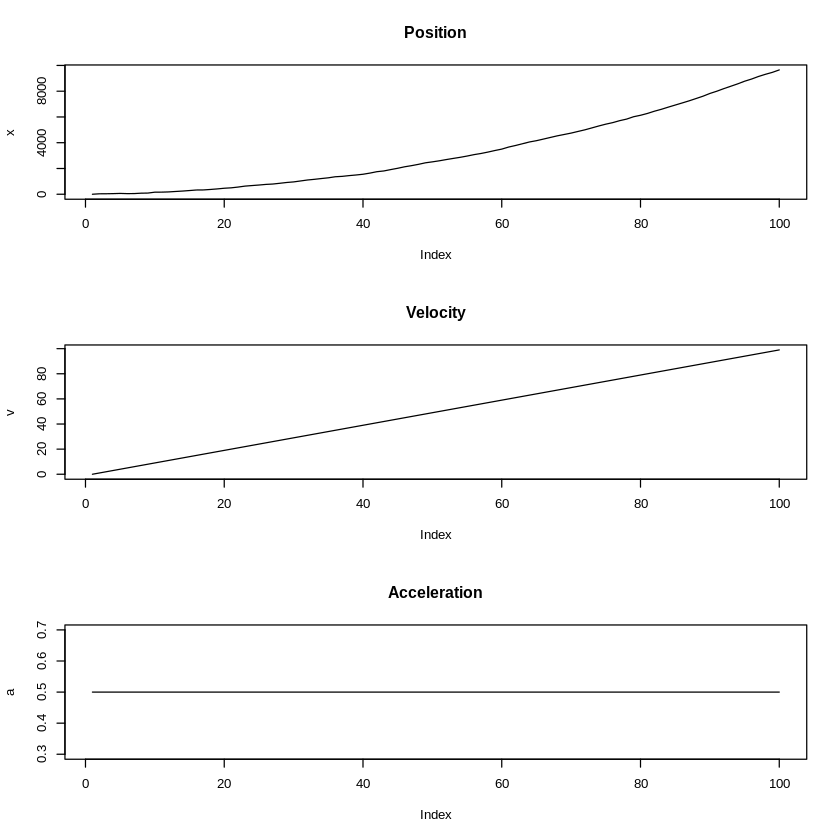

In [ ]:
par(mfrow= c(3,1))
plot(x, main= "Position", type= "l")
plot(v, main= "Velocity", type= "l")
plot(a, main= "Acceleration", type= "l")

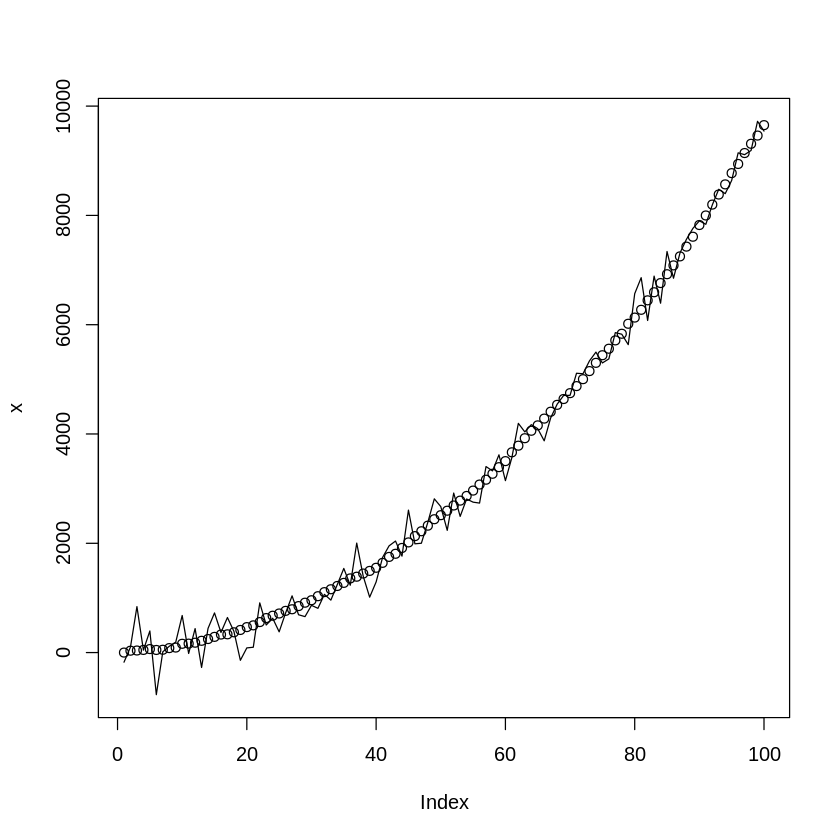

In [ ]:
z= x + rnorm(ts.length, sd= 300)
plot(x, ylim= range(c(x,z)))
lines(z)

In [ ]:
# Aplicando
kalman.motion <- function(z, Q, R, A, H) {
  dimState = dim(Q)[1]

  xhatminus <- array(rep(0, ts.length * dimState),
                     c(ts.length, dimState))
  xhat      <- array(rep(0, ts.length * dimState),
                     c(ts.length, dimState))

  Pminus  <- array(rep(0, ts.length * dimState * dimState),
                   c(ts.length, dimState, dimState))
  P       <- array(rep(0, ts.length * dimState * dimState),
                   c(ts.length, dimState, dimState))

  K <- array(rep(0, ts.length * dimState),
             c(ts.length, dimState)) # Kalman gain

  # Estimativas iniciais = começando em 0 para todas as métricas
  xhat[1, ] <- rep(0, dimState)
  P[1, , ]  <- diag(dimState)

  for (k in 2:ts.length) {
    # Att do tempo
    xhatminus[k, ] <- A %*% matrix(xhat[k-1, ])
    Pminus[k, , ] <- A %*% P[k-1, , ] %*% t(A) + Q

    K[k, ] <- Pminus[k, , ] %*% H %*%
                            solve( t(H) %*% Pminus[k, , ] %*% H + R )
    xhat[k, ] <- xhatminus[k, ] + K[k, ] %*%
                            (z[k] - t(H) %*% xhatminus[k, ])
    P[k, , ] <- (diag(dimState) - K[k, ] %*% t(H)) %*% Pminus[k, , ]
  }

  # Retornamos a previsão e o valor suavizado
  return(list(xhat = xhat, xhatminus = xhatminus))
}

In [ ]:
# Parametros de ruidos
R <- 10^2
Q <- 10

# Parametros dinamicas
A <- matrix(1) ## x_t = A * x_t - 1
H <- matrix(1) ## y_t = H * x_t

In [ ]:
xhat <- kalman.motion(z, diag(1) * Q, R, A, H)[[1]]
xhatminus <- kalman.motion(z, diag(1) * Q, R, A, H)[[2]]

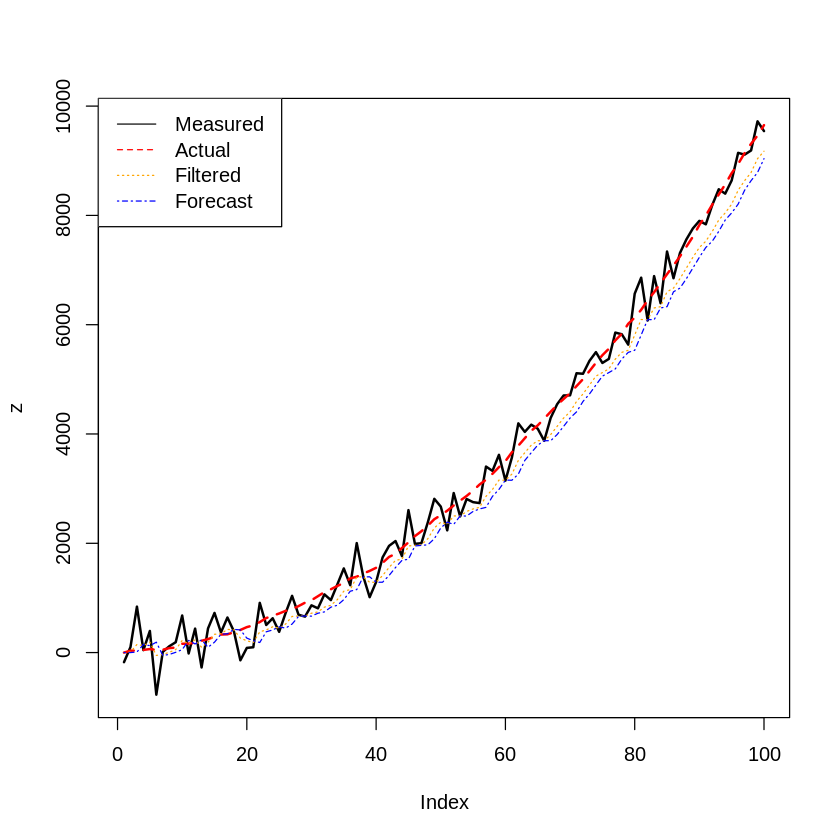

In [ ]:
## visualization
plot(z, ylim = range(c(x, z)), type = 'l',
                 col = "black",  lwd = 2)
lines(x,         col = "red",    lwd = 2, lty = 2)
lines(xhat,      col = "orange", lwd = 1, lty = 3)
lines(xhatminus, col = "blue",   lwd = 1, lty = 4)
legend("topleft",
       legend = c("Measured", "Actual", "Filtered", "Forecast"),
       col = c("black", "red", "orange", "blue"),
       lty = 1:4)

# Modelos ocultos de Markov (HMM) Ou mpdelos de mistura com dependencia

*No codigo, buscaremos inspiração em um exemplo do mercado de ações por meio dos cenarios bull market (ações em alta), bear market (ações em queda), neutro(ações estaveis) e panicos.*

In [ ]:
set.seed(123)

# definir os parametros para a distribuição de cada um dos 4 estados de mercado que queremos representar
bull_mu= 0.1
bull_sd= 0.1

neural_mu= 0.02
neural_sd= 0.08

bear_mu= -0.03
bear_sd= 0.2

panic_mu= -0.1
panic_sd= 0.3

# Coleta esses parâmetros em vetores para fácil indexação
mus= c(bull_mu, neural_mu, bear_mu, panic_mu)
sds= c(bull_sd, neural_sd, bear_sd, panic_sd)

# Define algumas constantes para representar a série temporal que geraremos
NUM.PERIODS= 10
SMALLEST.PERIODS= 20
LONGEST.PERIODS= 40

# Determina estocasticamente uma serie de contagens de dias, cada contagem de dias indica uma "execução" ou um estado do mercado

days= sample(SMALLEST.PERIODS:LONGEST.PERIODS, NUM.PERIODS, replace= TRUE)

# Para cada número de dias no vetor days, geramos uma serie temporal para essa serie de dias em um determinado estado do mercado
# e a adicionamos à nossa serie temporal geral
returns = numeric()
true.mean= numeric()

for(d in days) {
  idx= sample(1:4, 1, prob= c(0.2, 0.6, 0.18, 0.02))
  returns= c(returns, rnorm(d, mean= mus[idx], sd= sds[idx]))
  true.mean= c(true.mean, rep(mus[idx], d))
}

*Embora pretendessemos incluir quatro estados na serie simulada, apenas tres foram incluidos. Provavelmente, o quarto estado tevve uma probabilidade muito abaixo de inclusão (0.02)*

In [ ]:
table(true.mean)

true.mean
-0.03  0.02   0.1 
   66   142   111 

In [ ]:
require(depmixS4)

In [ ]:
hmm.model = depmix(returns ~ 1, family= gaussian(), nstates= 4, data= data.frame(returns= returns))
hmm.model

Initial state probabilities model 
 pr1  pr2  pr3  pr4 
0.25 0.25 0.25 0.25 

Transition matrix 
       toS1 toS2 toS3 toS4
fromS1 0.25 0.25 0.25 0.25
fromS2 0.25 0.25 0.25 0.25
fromS3 0.25 0.25 0.25 0.25
fromS4 0.25 0.25 0.25 0.25

Response parameters 
Resp 1 : gaussian 
    Re1.(Intercept) Re1.sd
St1               0      1
St2               0      1
St3               0      1
St4               0      1

In [ ]:
model.fit= fit(hmm.model)
model.fit

converged at iteration 357 with logLik: 265.7247 


Convergence info: Log likelihood converged to within tol. (relative change) 
'log Lik.' 265.7247 (df=23)
AIC:  -485.4494 
BIC:  -398.85 

In [ ]:
post_probs= posterior(model.fit)
post_probs

Warning message in .local(object, ...):
“Argument 'type' not specified and will default to 'viterbi'. This default may change in future releases of depmixS4. Please see ?posterior for alternative options.”


state,S1,S2,S3,S4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.0000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.9897952,0.000000e+00,1.020480e-02,2.297022e-21
1,0.9767141,4.066228e-23,3.008680e-08,2.328583e-02
1,0.9990198,1.137925e-04,8.647148e-04,1.737436e-06
1,0.9338210,3.623825e-05,6.610265e-02,4.015589e-05
1,0.9999500,4.976322e-05,2.343172e-07,6.292105e-09
1,0.9346576,1.583469e-05,6.532656e-02,3.980731e-08
1,0.9351019,5.576085e-06,5.563336e-02,9.259172e-03
1,0.8763665,6.371079e-05,5.510829e-05,1.235146e-01


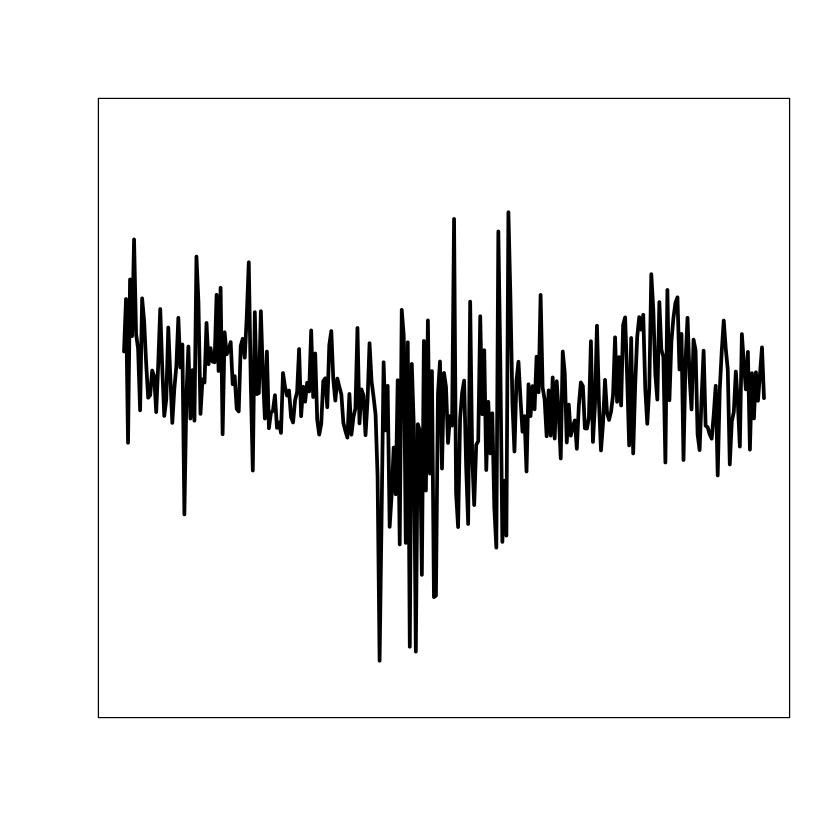

In [ ]:
plot(returns, type= "l", lwd= 3, col= 1, yaxt= "n", xaxt= "n", xlab= "", ylab= "", ylim= c(-0.6, 0.6))
lapply(0:(length(returns) - 1), function(i){
  rect(i, -0.6, (i + 1), 0.6,
       col= rgb(0.0, 0.0, 0.0, alpha= (0.2 * post_probs$state[i + 1])),
       border= NA)
})